In [1]:
!pip install transformers torch scikit-learn --quiet

import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# # Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00
Using device: cuda


In [3]:
!pip install textblob --quiet
import re

from textblob import TextBlob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
# Adjust the file path if necessary
train_path = "/content/drive/MyDrive/train.csv"
valid_path = "/content/drive/MyDrive/valid.csv"
train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
print("Train shape:", train_df.shape)
print(train_df.head())

# Encode the target label column (e.g., "HQ", "LQ_EDIT", "LQ_CLOSE")
label_encoder = LabelEncoder()
train_df["Y"] = label_encoder.fit_transform(train_df["Y"])
print("Unique labels:", train_df["Y"].unique())
print("Encoded labels:", np.unique(train_df["Y"]))

for index, class_ in enumerate(label_encoder.classes_):
    print(f"Integer {index} corresponds to label '{class_}'")


Train shape: (45000, 6)
         Id                                              Title  \
0  34552656             Java: Repeat Task Every Random Seconds   
1  34553034                  Why are Java Optionals immutable?   
2  34553174  Text Overlay Image with Darkened Opacity React...   
3  34553318         Why ternary operator in swift is so picky?   
4  34553755                 hide/show fab with scale animation   

                                                Body  \
0  <p>I'm already familiar with repeating tasks e...   
1  <p>I'd like to understand why Java 8 Optionals...   
2  <p>I am attempting to overlay a title over an ...   
3  <p>The question is very simple, but I just cou...   
4  <p>I'm using custom floatingactionmenu. I need...   

                                                Tags         CreationDate  \
0                                     <java><repeat>  2016-01-01 00:21:59   
1                                   <java><optional>  2016-01-01 02:03:20   
2  <javascr

In [5]:
def basic_preprocessing(text):
    """
    Basic text preprocessing:
    - Lowercases the text.
    - Removes non-alphanumeric characters.
    - Strips extra spaces.
    """
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Combine "title" and "body" (fill missing values) and preprocess
train_df["processed_text"] = (
    train_df["Title"].fillna("") + " " + train_df["Body"].fillna("")
).apply(basic_preprocessing)
valid_df["processed_text"] = (
    train_df["Title"].fillna("") + " " + train_df["Body"].fillna("")
).apply(basic_preprocessing)

# Display a preview of the processed text
train_df[["Title", "Body", "processed_text"]].head()


,Title,Body,processed_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat task every random seconds pim alre...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,why are java optionals immutable pid like to u...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,text overlay image with darkened opacity react...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",why ternary operator in swift is so picky pthe...
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,hideshow fab with scale animation pim using cu...


In [6]:
class BertEmbeddingGenerator:
    def __init__(self, model_name="bert-base-uncased", max_length=128):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.to(device)
        self.model.eval()  # set model to evaluation mode
        self.max_length = max_length

    def get_embedding(self, text):
        """
        Returns the [CLS] embedding for a given text using BERT.
        """
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            # Use the [CLS] token representation as the sentence embedding
            cls_embedding = outputs.last_hidden_state[:, 0, :]
        return cls_embedding.squeeze().cpu().numpy()

# Instantiate the embedding generator
embedder = BertEmbeddingGenerator(model_name="bert-base-uncased", max_length=128)

# Test the embedding generator on a sample text
sample_text = train_df["processed_text"].iloc[0]
sample_embedding = embedder.get_embedding(sample_text)
print("Sample embedding shape:", sample_embedding.shape)  # Expected shape: (768,)
# print(sample_embedding)
# embeddings = []

# for text in train_df["processed_text"]:
#     embedding = embedder.get_embedding(text)
#     embeddings.append(embedding)
# embedding_matrix = np.vstack(embeddings)
# print("Embedding matrix shape:", embedding_matrix.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sample embedding shape: (768,)


In [7]:
from transformers import TFBertModel
import tensorflow as tf

def subjectiveIndicator(model_path=None, max_seq_len=128):
    """
    Loads or builds a BERT-based Keras model that outputs 20 subjective features.
    If model_path is provided, loads weights from that local file.
    Otherwise, uses a fresh TFBertModel from HuggingFace.
    """
    # Load the BERT base (either your local weights or directly from HF)
    if model_path is not None:
        # e.g. "bert-base-uncased-tf_model.h5" or a saved model directory
        base_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=False)
        base_model.load_weights(model_path)
    else:
        base_model = TFBertModel.from_pretrained("bert-base-uncased")

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")

    # Get BERT outputs
    outputs = base_model(input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output  # [CLS] hidden state

    # Example: add a hidden layer before final
    hidden = tf.keras.layers.Dense(256, activation="relu")(pooled_output)
    drop = tf.keras.layers.Dropout(0.2)(hidden)

    # Final Dense for 20 subjective features (multi-label => sigmoid)
    subj_out = tf.keras.layers.Dense(20, activation="sigmoid")(drop)

    # Build the complete model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=subj_out)

    # Compile with binary crossentropy for multi-label classification
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [8]:
import tensorflow as tf
from transformers import TFBertModel

def simulate_subjective_indicators(texts, max_len=128, batch_size=32):
    """
    Returns a (num_samples, 20) array of pseudo-subjective indicators
    using frozen BERT and a randomly initialized dense layer.
    Processes in batches to avoid OOM.
    """
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = TFBertModel.from_pretrained("bert-base-uncased")
    subjective_head = tf.keras.layers.Dense(20, activation="sigmoid", name="subjective_head")

    # Tokenize all texts
    encodings = tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )

    dataset = tf.data.Dataset.from_tensor_slices((
        encodings["input_ids"],
        encodings["attention_mask"]
    )).batch(batch_size)

    all_outputs = []

    for batch_input_ids, batch_attention_mask in dataset:
        outputs = bert(batch_input_ids, attention_mask=batch_attention_mask)
        cls_embeddings = outputs.pooler_output  # (batch_size, 768)
        subj_output = subjective_head(cls_embeddings)  # (batch_size, 20)
        all_outputs.append(subj_output.numpy())

    return np.vstack(all_outputs)  # shape: (num_samples, 20)


In [ ]:
texts = train_df["processed_text"].astype(str).tolist()

# Simulate subjective features
subj_feats = simulate_subjective_indicators(texts, batch_size=32)

print(subj_feats.shape)  # (num_samples, 20)
print(subj_feats[0])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

(45000, 20)
[0.3034901  0.24514775 0.68725795 0.6229294  0.50956047 0.3226088
 0.78662217 0.5037363  0.5648674  0.2269984  0.3323931  0.47952035
 0.7778459  0.610595   0.69815063 0.61895657 0.342345   0.595224
 0.22984292 0.4069996 ]


In [ ]:
subj_df = pd.DataFrame(subj_feats, columns=[f"subj_feat_{i+1}" for i in range(20)])
df_with_subj = pd.concat([train_df.reset_index(drop=True), subj_df], axis=1)
df_with_subj.to_csv("train_with_subjective.csv", index=False)

In [9]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Use the correct path from Drive or local Colab file system
model_dir = "/content/drive/MyDrive/Ner"  # adjust this path

# Load the uncased tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForTokenClassification.from_pretrained(model_dir)
model.to(device)

model.eval()

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

In [10]:
print("Number of labels:", model.config.num_labels)
print("id2label:", model.config.id2label)
print("label2id:", model.config.label2id)

Number of labels: 55
id2label: {0: '-', 1: '--', 2: '----', 3: 'B-Algorithm', 4: 'B-Application', 5: 'B-Class', 6: 'B-Code_Block', 7: 'B-Data_Structure', 8: 'B-Data_Type', 9: 'B-Device', 10: 'B-Error_Name', 11: 'B-File_Name', 12: 'B-File_Type', 13: 'B-Function', 14: 'B-HTML_XML_Tag', 15: 'B-Keyboard_IP', 16: 'B-Language', 17: 'B-Library', 18: 'B-Licence', 19: 'B-Operating_System', 20: 'B-Organization', 21: 'B-Output_Block', 22: 'B-User_Interface_Element', 23: 'B-User_Name', 24: 'B-Value', 25: 'B-Variable', 26: 'B-Version', 27: 'B-Website', 28: 'I-Algorithm', 29: 'I-Application', 30: 'I-Class', 31: 'I-Code_Block', 32: 'I-Data_Structure', 33: 'I-Data_Type', 34: 'I-Device', 35: 'I-Error_Name', 36: 'I-File_Name', 37: 'I-File_Type', 38: 'I-Function', 39: 'I-HTML_XML_Tag', 40: 'I-Keyboard_IP', 41: 'I-Language', 42: 'I-Library', 43: 'I-Licence', 44: 'I-Operating_System', 45: 'I-Output_Block', 46: 'I-User_Interface_Element', 47: 'I-User_Name', 48: 'I-Value', 49: 'I-Variable', 50: 'I-Version', 

In [11]:
from torch.utils.data import DataLoader, TensorDataset

def ner_inference(texts, tokenizer, model, device, max_length=128, batch_size=32):

    # Tokenize the entire batch at once
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]

    dataset = TensorDataset(input_ids, attention_mask)
    loader = DataLoader(dataset, batch_size=batch_size)

    all_results = []

    with torch.no_grad():
        for batch in loader:
            batch_input_ids, batch_attention_mask = [x.to(device) for x in batch]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            # Move results to CPU for processing
            batch_input_ids = batch_input_ids.cpu().numpy()
            preds = preds.cpu().numpy()

            for token_ids, label_ids in zip(batch_input_ids, preds):
                tokens = tokenizer.convert_ids_to_tokens(token_ids)
                token_labels = []
                for token, label_id in zip(tokens, label_ids):
                    if token in ["[CLS]", "[SEP]", "<pad>"]:
                        continue
                    label_str = model.config.id2label.get(label_id, "O")
                    token_labels.append((token, label_str))
                all_results.append(token_labels)

    return all_results


In [12]:
def ner_features(token_label_pairs):
    """
    Given a list of (token, label) from softner_inference(),
    return a dict counting how many times each label appears.
    """
    counts = {}
    for tok, lab in token_label_pairs:
        if tok in ["[CLS]", "[SEP]", "[PAD]"]:
            continue
        counts[lab] = counts.get(lab, 0) + 1
    return counts


In [13]:
text = "I used MySQL database with a Python variable foo"
ents = ner_inference([text], tokenizer, model, device)[0]
for token, label in ents:
    print(f"{token:15} --> {label}")
feats = ner_features(ents)
print(feats)
# e.g. {"O": 5, "DATABASE": 1, "VARIABLE": 1, ...}


<s>             --> O
I               --> O
Ġused           --> O
ĠMySQL          --> B-Language
Ġdatabase       --> O
Ġwith           --> O
Ġa              --> O
ĠPython         --> B-Language
Ġvariable       --> O
Ġfoo            --> B-Variable
</s>            --> O
{'O': 8, 'B-Language': 2, 'B-Variable': 1}


In [ ]:
all_features = []
batch_size = 32
texts = train_df["processed_text"].astype(str).tolist()

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_results = ner_inference(batch_texts, tokenizer, model, device, max_length=128)
    for token_label_pairs in batch_results:
        feat_dict = ner_features(token_label_pairs)
        all_features.append(feat_dict)

    print(f"Processed batch {i // batch_size + 1} ({i + len(batch_texts)} / {len(texts)})")

ner_df = pd.DataFrame(all_features).fillna(0)
df_ner = pd.concat([train_df.reset_index(drop=True), ner_df], axis=1)
df_ner.to_csv("train_with_ner.csv", index=False)

Processed batch 1 (32 / 45000)
Processed batch 2 (64 / 45000)
Processed batch 3 (96 / 45000)
Processed batch 4 (128 / 45000)
Processed batch 5 (160 / 45000)
Processed batch 6 (192 / 45000)
Processed batch 7 (224 / 45000)
Processed batch 8 (256 / 45000)
Processed batch 9 (288 / 45000)
Processed batch 10 (320 / 45000)
Processed batch 11 (352 / 45000)
Processed batch 12 (384 / 45000)
Processed batch 13 (416 / 45000)
Processed batch 14 (448 / 45000)
Processed batch 15 (480 / 45000)
Processed batch 16 (512 / 45000)
Processed batch 17 (544 / 45000)
Processed batch 18 (576 / 45000)
Processed batch 19 (608 / 45000)
Processed batch 20 (640 / 45000)
Processed batch 21 (672 / 45000)
Processed batch 22 (704 / 45000)
Processed batch 23 (736 / 45000)
Processed batch 24 (768 / 45000)
Processed batch 25 (800 / 45000)
Processed batch 26 (832 / 45000)
Processed batch 27 (864 / 45000)
Processed batch 28 (896 / 45000)
Processed batch 29 (928 / 45000)
Processed batch 30 (960 / 45000)
Processed batch 31 (99

In [ ]:
ner_df = pd.read_csv("train_with_ner.csv")
subj_df = pd.read_csv("/content/drive/MyDrive/train_with_subjective.csv")

# Drop duplicate columns (except for 'Id' if used as key)
common_cols = set(ner_df.columns) & set(subj_df.columns)
cols_to_drop = [col for col in common_cols if col != 'Id']
subj_df = subj_df.drop(columns=cols_to_drop)

# Concatenate on rows with reset index
merged_df = pd.concat([ner_df.reset_index(drop=True), subj_df.reset_index(drop=True)], axis=1)

# Save or use
merged_df.to_csv("train_merged.csv", index=False)

In [14]:
df = pd.read_csv('/content/drive/MyDrive/train_merged.csv')
df.head()

,Id,Title,Body,Tags,CreationDate,Y,processed_text,O,B-Language,B-Library,...,subj_feat_11,subj_feat_12,subj_feat_13,subj_feat_14,subj_feat_15,subj_feat_16,subj_feat_17,subj_feat_18,subj_feat_19,subj_feat_20
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,1,java repeat task every random seconds pim alre...,56.0,1.0,4.0,...,0.332393,0.479520,0.777846,0.610595,0.698151,0.618957,0.342345,0.595224,0.229843,0.407000
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,0,why are java optionals immutable pid like to u...,22.0,2.0,0.0,...,0.371032,0.452007,0.749921,0.656861,0.714080,0.644150,0.293702,0.611762,0.234797,0.443112
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,0,text overlay image with darkened opacity react...,86.0,0.0,2.0,...,0.397289,0.533651,0.705417,0.677571,0.664553,0.653888,0.233543,0.620301,0.325871,0.492110
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,0,why ternary operator in swift is so picky pthe...,94.0,0.0,1.0,...,0.393385,0.507251,0.755828,0.679308,0.629112,0.588271,0.321993,0.565804,0.237159,0.411909
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,0,hideshow fab with scale animation pim using cu...,73.0,0.0,0.0,...,0.292074,0.467954,0.766447,0.605255,0.745469,0.655420,0.294444,0.604168,0.246374,0.408546


In [15]:
def extract_lexical_features(title, body):
    """
    Returns a dictionary of lexical & sentiment features from title & body.
    Includes:
      - letter_count, word_count
      - code_block detection & code percentage
      - first/last sentence word count, average sentence word count
      - sentiment (TextBlob polarity, subjectivity)
      - whether the title is interrogative
    """

    features = {}

    # 1. Title letter/word count
    title_letters = len(title)
    title_words = len(title.split())
    features["title_letter_count"] = title_letters
    features["title_word_count"] = title_words

    # 2. Body letter/word count
    body_letters = len(body)
    body_words = len(body.split())
    features["body_letter_count"] = body_letters
    features["body_word_count"] = body_words

    # 3. Simple code block detection & code percentage
    #    We'll count the total length of all <code>...</code> blocks
    code_blocks = re.findall(r"<code>(.*?)</code>", body, flags=re.DOTALL)
    code_text = "".join(code_blocks)
    code_length = len(code_text)
    total_length = len(body)
    code_pct = (code_length / total_length) if total_length > 0 else 0
    features["code_percentage"] = code_pct
    features["code_block_count"] = len(code_blocks)

    # 4. Sentence-level features for the body
    #    We'll split by '.' as a simple approach. You might refine with nltk/sentence-split.
    sentences = [s.strip() for s in body.split('.') if s.strip()]
    if len(sentences) > 0:
        first_sentence = sentences[0]
        last_sentence = sentences[-1]
        features["first_sentence_word_count"] = len(first_sentence.split())
        features["last_sentence_word_count"] = len(last_sentence.split())
        # average words per sentence
        avg_words = np.mean([len(s.split()) for s in sentences])
        features["avg_sentence_word_count"] = avg_words
    else:
        features["first_sentence_word_count"] = 0
        features["last_sentence_word_count"] = 0
        features["avg_sentence_word_count"] = 0

    # 5. Simple sentiment (TextBlob) for title/body
    title_blob = TextBlob(title)
    body_blob = TextBlob(body)
    features["title_sentiment_polarity"] = title_blob.sentiment.polarity
    features["title_sentiment_subjectivity"] = title_blob.sentiment.subjectivity
    features["body_sentiment_polarity"] = body_blob.sentiment.polarity
    features["body_sentiment_subjectivity"] = body_blob.sentiment.subjectivity

    # 6. Interrogative title (check if title ends with '?')
    features["title_is_interrogative"] = int(title.strip().endswith('?'))

    return features


In [16]:
def extract_softner_features(row, ner_labels):
    """
    row: a single row from the DataFrame (Series or namedtuple).
    ner_labels: list of SoftNER label columns, e.g. ["DATABASE", "VARIABLE", "ALGORITHM", ...]

    We assume each column in ner_labels has a count of how many tokens had that label.
    Return a dict of total_ner_tokens, plus count and percentage for each label.
    """
    feats = {}
    # sum up total tokens recognized (including O or not, up to you)
    total_tokens = 0
    for label in ner_labels:
        if label in row:
            val = row[label]
            total_tokens += val

    feats["total_ner_tokens"] = total_tokens

    # For each label, store count and percentage
    for label in ner_labels:
        if label in row:
            count = row[label]
            feats[f"{label}_count"] = count
            if total_tokens > 0:
                feats[f"{label}_pct"] = count / total_tokens
            else:
                feats[f"{label}_pct"] = 0.0
    return feats

In [17]:
ner_label_cols = [
    col for col in df.columns
    if col == "O" or col.startswith("B-") or col.startswith("I-")
]

print("Detected NER label columns:", ner_label_cols)

Detected NER label columns: ['O', 'B-Language', 'B-Library', 'I-Library', 'I-Function', 'B-Value', 'I-Value', 'B-Application', 'B-User_Name', 'B-Data_Type', 'B-Variable', 'B-Version', 'I-Variable', 'B-User_Interface_Element', 'B-Device', 'B-Code_Block', 'I-Code_Block', 'B-Function', 'B-Class', 'I-User_Interface_Element', 'I-Application', 'B-Output_Block', 'I-Output_Block', 'B-HTML_XML_Tag', 'I-HTML_XML_Tag', 'B-Operating_System', 'I-Error_Name', 'B-Error_Name', 'I-Operating_System', 'B-Website', 'B-Data_Structure', 'B-File_Name', 'I-File_Name', 'I-Device', 'B-File_Type', 'I-Class', 'I-User_Name', 'I-Algorithm', 'I-Data_Type', 'I-Version', 'I-Language', 'B-Algorithm', 'I-Data_Structure', 'I-Website', 'B-Keyboard_IP', 'I-Keyboard_IP']


In [18]:
all_stats = []
for idx, row in df.iterrows():
    title = row.get("Title", "")  # Adjust column names if needed
    body = row.get("Body", "")

    lexical_dict = extract_lexical_features(title, body)
    ner_dict = extract_softner_features(row, ner_label_cols)

    combined = {**lexical_dict, **ner_dict}
    all_stats.append(combined)

stats_df = pd.DataFrame(all_stats)

# Merge the new features with the original DataFrame
df_stats = pd.concat([df.reset_index(drop=True), stats_df], axis=1)
df_stats.to_csv("train_stats.csv", index=False)

In [18]:
df_stats = pd.read_csv("/content/drive/MyDrive/train_stats.csv")

df_stats.head()

,Id,Title,Body,Tags,CreationDate,Y,processed_text,O,B-Language,B-Library,...,B-Algorithm_count,B-Algorithm_pct,I-Data_Structure_count,I-Data_Structure_pct,I-Website_count,I-Website_pct,B-Keyboard_IP_count,B-Keyboard_IP_pct,I-Keyboard_IP_count,I-Keyboard_IP_pct
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,1,java repeat task every random seconds pim alre...,56.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,0,why are java optionals immutable pid like to u...,22.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,0,text overlay image with darkened opacity react...,86.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,0,why ternary operator in swift is so picky pthe...,94.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,0,hideshow fab with scale animation pim using cu...,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print("Original columns:", df_stats.columns.tolist())
print("Shape:", df_stats.shape)

Original columns: ['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Y', 'processed_text', 'O', 'B-Language', 'B-Library', 'I-Library', 'I-Function', 'B-Value', 'I-Value', 'B-Application', 'B-User_Name', 'B-Data_Type', 'B-Variable', 'B-Version', 'I-Variable', 'B-User_Interface_Element', 'B-Device', 'B-Code_Block', 'I-Code_Block', 'B-Function', 'B-Class', 'I-User_Interface_Element', 'I-Application', 'B-Output_Block', 'I-Output_Block', 'B-HTML_XML_Tag', 'I-HTML_XML_Tag', 'B-Operating_System', 'I-Error_Name', 'B-Error_Name', 'I-Operating_System', 'B-Website', 'B-Data_Structure', 'B-File_Name', 'I-File_Name', 'I-Device', 'B-File_Type', 'I-Class', 'I-User_Name', 'I-Algorithm', 'I-Data_Type', 'I-Version', 'I-Language', 'B-Algorithm', 'I-Data_Structure', 'I-Website', 'B-Keyboard_IP', 'I-Keyboard_IP', 'Id.1', 'subj_feat_1', 'subj_feat_2', 'subj_feat_3', 'subj_feat_4', 'subj_feat_5', 'subj_feat_6', 'subj_feat_7', 'subj_feat_8', 'subj_feat_9', 'subj_feat_10', 'subj_feat_11', 'subj_feat_12', 'subj_

In [44]:
# A) Subjective columns (20 features from Component 1)
subjective_col_map = {
    "subj_feat_1": "Clear intent",
    "subj_feat_2": "Conversational",
    "subj_feat_3": "Expects short answer",
    "subj_feat_4": "Fact seeking",
    "subj_feat_5": "Has accepted answer",
    "subj_feat_6": "Interestingness others",
    "subj_feat_7": "Interestingness self",
    "subj_feat_8": "Multi intent",
    "subj_feat_9": "Not a question",
    "subj_feat_10": "Opinion seeking",
    "subj_feat_11": "Type-choice",
    "subj_feat_12": "Type-compare",
    "subj_feat_13": "Type-consequence",
    "subj_feat_14": "Type-definition",
    "subj_feat_15": "Type-entity",
    "subj_feat_16": "Type-instructions",
    "subj_feat_17": "Type-procedure",
    "subj_feat_18": "Type-reason explanation",
    "subj_feat_19": "Type-spelling",
    "subj_feat_20": "Well written"
}

# B) Software-related columns (from SoftNER outputs)


# C) Lexical/statistical columns (from general statistical analysis in Component 3)
lexical_cols = [
    "title_letter_count", "title_word_count",
    "body_letter_count", "body_word_count",
    "code_percentage", "code_block_count",
    "first_sentence_word_count", "last_sentence_word_count",
    "avg_sentence_word_count",
    "title_sentiment_polarity", "title_sentiment_subjectivity",
    "body_sentiment_polarity", "body_sentiment_subjectivity",
    "title_is_interrogative"
]

# D) ID/Label/Other essential columns (adjust as necessary)
id_cols = ["Id", "Title", "Body", "Tags", "CreationDate", "processed_text", "Y"]


In [48]:
df_stats.rename(columns=subjective_col_map, inplace=True)

# 2) Create a list of the *new* column names (the "values" of the map)
#    This will be your official subjective feature list.
subjective_cols = list(subjective_col_map.values())

# 3) Filter them to ensure they exist in df_stats (in case any are missing)
subjective_in_df = [col for col in subjective_cols if col in df_stats.columns]

lexical_in_df    = [col for col in lexical_cols if col in df_stats.columns]
id_in_df         = [col for col in id_cols if col in df_stats.columns]

id_set         = set(id_cols)
subjective_set = set(subjective_cols)
lexical_set    = set(lexical_cols)

all_cols = set(df_stats.columns)

software_set = all_cols - id_set - subjective_set - lexical_set
software_in_df = list(software_set)

# -------------------------------
# 4. Create separate DataFrames for each category, including ID columns
# -------------------------------
df_subjective = df_stats[id_in_df + subjective_in_df]
df_software   = df_stats[id_in_df + software_in_df]
df_lexical    = df_stats[id_in_df + lexical_in_df]

In [54]:
df_subjective.to_csv("train_subjective.csv", index=False)
df_software.to_csv("train_software.csv", index=False)
df_lexical.to_csv("train_lexical.csv", index=False)

In [52]:
df_subjective.columns


Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'processed_text', 'Y',
       'Clear intent', 'Conversational', 'Expects short answer',
       'Fact seeking', 'Has accepted answer', 'Interestingness others',
       'Interestingness self', 'Multi intent', 'Not a question',
       'Opinion seeking', 'Type-choice', 'Type-compare', 'Type-consequence',
       'Type-definition', 'Type-entity', 'Type-instructions', 'Type-procedure',
       'Type-reason explanation', 'Type-spelling', 'Well written'],
      dtype='object')

In [50]:
print(df_software.columns.tolist())


['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'processed_text', 'Y', 'I-Class', 'I-Library_pct', 'B-Output_Block_count', 'I-Library_count', 'B-File_Type_pct', 'B-Algorithm_count', 'B-Variable_pct', 'I-File_Name_pct', 'B-Version_pct', 'I-Error_Name_pct', 'B-Value_pct', 'B-Data_Type_count', 'I-User_Interface_Element_count', 'I-Version_count', 'B-User_Interface_Element', 'B-Website', 'I-Data_Type_count', 'B-File_Type_count', 'B-Keyboard_IP_count', 'B-Application_count', 'B-Code_Block_count', 'I-Algorithm_pct', 'B-Keyboard_IP_pct', 'I-Output_Block_count', 'B-File_Name', 'B-Application_pct', 'Id.1', 'I-Device_count', 'B-Error_Name_pct', 'I-Algorithm', 'B-Class_pct', 'B-Operating_System_count', 'I-Language', 'B-Device', 'I-Output_Block', 'B-Website_count', 'I-Function_pct', 'B-Function_count', 'I-Data_Structure_count', 'B-HTML_XML_Tag_count', 'I-HTML_XML_Tag_count', 'B-Class', 'I-Code_Block_pct', 'B-Version', 'B-Language', 'I-Operating_System', 'B-Code_Block_pct', 'B-Error_Name_count', 'I-

In [37]:
df_lexical.columns


Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'processed_text', 'Y',
       'title_letter_count', 'title_word_count', 'body_letter_count',
       'body_word_count', 'code_percentage', 'code_block_count',
       'first_sentence_word_count', 'last_sentence_word_count',
       'avg_sentence_word_count', 'title_sentiment_polarity',
       'title_sentiment_subjectivity', 'body_sentiment_polarity',
       'body_sentiment_subjectivity', 'title_is_interrogative'],
      dtype='object')

In [32]:
df_stats.columns

Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Y', 'processed_text',
       'O', 'B-Language', 'B-Library',
       ...
       'B-Algorithm_count', 'B-Algorithm_pct', 'I-Data_Structure_count',
       'I-Data_Structure_pct', 'I-Website_count', 'I-Website_pct',
       'B-Keyboard_IP_count', 'B-Keyboard_IP_pct', 'I-Keyboard_IP_count',
       'I-Keyboard_IP_pct'],
      dtype='object', length=181)

In [53]:
summary_data = []
df = df_stats
for col in df.columns:
    dtype = df[col].dtype
    unique_vals = df[col].nunique()

    # Initialize stats
    mean_val = ""
    min_val = ""
    max_val = ""

    if np.issubdtype(dtype, np.number):
        mean_val = round(df[col].mean(), 4)
        min_val = round(df[col].min(), 4)
        max_val = round(df[col].max(), 4)

    summary_data.append([col, dtype, unique_vals, mean_val, min_val, max_val])

# Create summary dataframe
summary_df = pd.DataFrame(summary_data, columns=["Column", "Data Type", "Unique Values", "Mean", "Min", "Max"])

# Save to text file
summary_df.to_string(buf=open("column_stats_summary.txt", "w"), index=False)


In [55]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
exclude_cols = ["Id", "Title", "Body", "Tags", "CreationDate", "processed_text", "Y"]
numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(["Y"]).tolist()

In [60]:
generated_feats = pd.DataFrame()

for col in numeric_cols:
    col_data = df[col].copy()

    # 1. Log transform safely: log1p ensures log(0) = 0 and avoids inf
    generated_feats[f"{col}_log"] = np.log1p(np.maximum(col_data, 0))

    # 2. Square transform (safe unless numbers are huge)
    generated_feats[f"{col}_sqr"] = np.power(col_data, 2)

    # 3. Sqrt transform safely
    generated_feats[f"{col}_sqrt"] = np.sqrt(np.maximum(col_data, 0))

<ipython-input-60-a60c3348e480>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  generated_feats[f"{col}_sqr"] = np.power(col_data, 2)
<ipython-input-60-a60c3348e480>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  generated_feats[f"{col}_sqrt"] = np.sqrt(np.maximum(col_data, 0))
<ipython-input-60-a60c3348e480>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [61]:
df_combined = pd.concat([df, generated_feats], axis=1)

In [62]:
feature_cols = df_combined.select_dtypes(include=[np.number]).columns.difference(["Y"])
scaler = MinMaxScaler()
df_combined[feature_cols] = scaler.fit_transform(df_combined[feature_cols])

In [63]:
tfidf = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf.fit_transform(df_combined["processed_text"].fillna(""))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])])

In [64]:
df_combined = pd.concat([df_combined.reset_index(drop=True), tfidf_df], axis=1)

In [65]:
correlations = df_combined.corr(numeric_only=True)["Y"].drop("Y")
low_corr_feats = correlations[correlations.abs() < 0.01].index.tolist()

# Drop those features
df_final = df_combined.drop(columns=low_corr_feats)

In [66]:
df_final.to_csv("train_features_final.csv", index=False)
print(f"✅ Final dataset saved with {df_final.shape[1]} columns.")
print(f"❌ Dropped {len(low_corr_feats)} low-correlation features.")

✅ Final dataset saved with 844 columns.
❌ Dropped 162 low-correlation features.


<ipython-input-67-5c9ed76dc7f9>:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


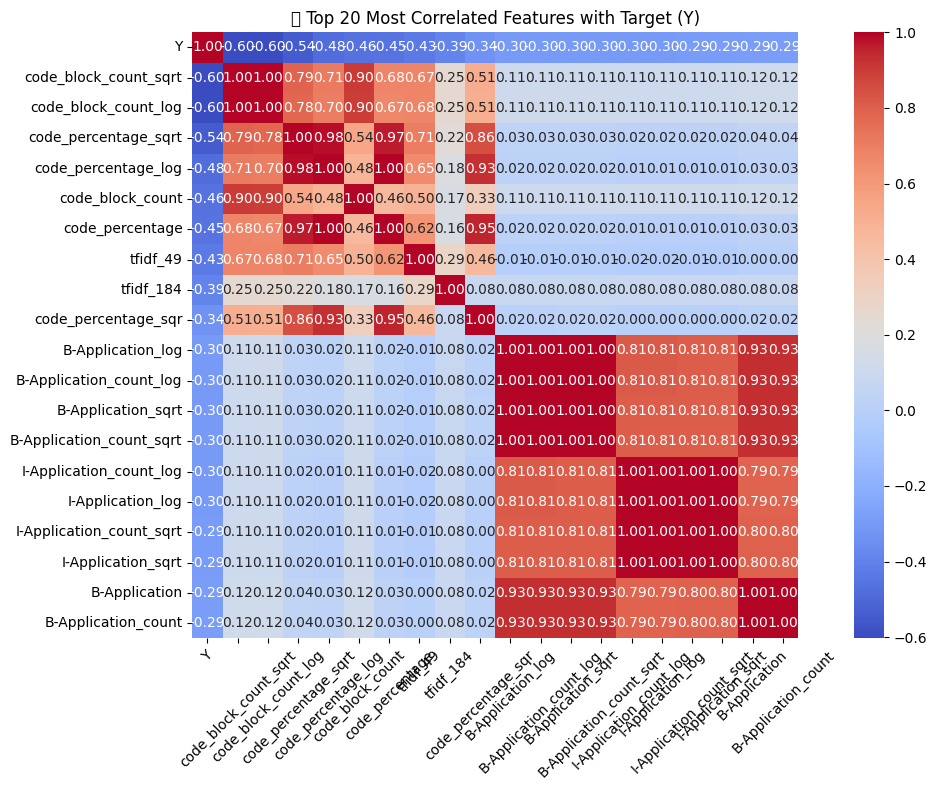

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 20 most correlated features with Y
top_corr = df_final.corr(numeric_only=True)["Y"].abs().sort_values(ascending=False).head(20).index
corr_matrix = df_final[top_corr].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("🔍 Top 20 Most Correlated Features with Target (Y)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-68-380929300ef3>:12: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


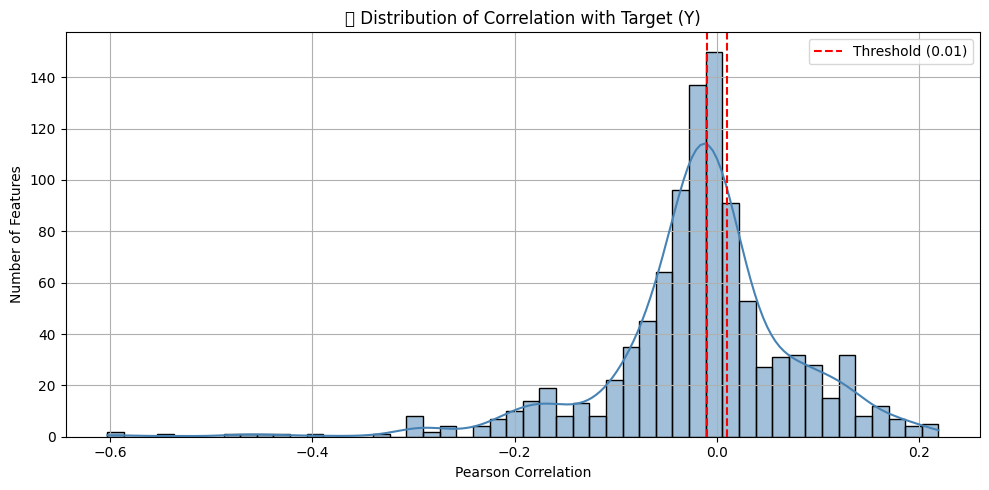

In [68]:
correlations = df_combined.corr(numeric_only=True)["Y"].drop("Y")

plt.figure(figsize=(10, 5))
sns.histplot(correlations, bins=50, kde=True, color='steelblue')
plt.axvline(0.01, color='red', linestyle='--', label='Threshold (0.01)')
plt.axvline(-0.01, color='red', linestyle='--')
plt.title("📉 Distribution of Correlation with Target (Y)")
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

df = pd.read_csv("train_features_final.csv")

In [71]:
exclude_cols = ["Id", "Title", "Body", "Tags", "CreationDate", "processed_text", "Y"]
X = df.drop(columns=exclude_cols, errors="ignore")
y = df["Y"].astype(int)

In [75]:
tasks = {
    "task_high_quality":   (y == 0).astype(int),  # 2 => High Quality
    "task_edit":           (y == 2).astype(int),  # 1 => Needs Edit
    "task_close":          (y == 1).astype(int)   # 0 => Should be Closed
}

In [78]:
xgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.07,
    "max_depth": 6,
    "colsample_bytree": 1.0,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "verbosity": 0,  # Silent training
    "tree_method": "gpu_hist"
}

In [79]:
results = {}  # will store Precision, Recall, F1 for each task

for task_name, binary_labels in tasks.items():
    # We'll do Stratified 5-fold CV for this binary classification
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for train_idx, val_idx in skf.split(X, binary_labels):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = binary_labels.iloc[train_idx], binary_labels.iloc[val_idx]

        # Instantiate and train XGBoost
        model = XGBClassifier(**xgb_params)
        model.fit(X_train, y_train)

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Compute metrics
        prec = precision_score(y_val, y_pred, zero_division=0)
        rec = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)

        fold_precisions.append(prec)
        fold_recalls.append(rec)
        fold_f1s.append(f1)

    # Average metrics across the 5 folds
    results[task_name] = {
        "Precision": np.mean(fold_precisions),
        "Recall":    np.mean(fold_recalls),
        "F1 Score":  np.mean(fold_f1s)
    }

In [80]:
results_df = pd.DataFrame(results).T.round(4)
print("XGBoost 5-Fold CV Results:")
print(results_df)

XGBoost 5-Fold CV Results:
                   Precision  Recall  F1 Score
task_high_quality     0.8542  0.8333    0.8436
task_edit             0.9484  0.9830    0.9654
task_close            0.8361  0.7584    0.7953


In [81]:
model_final = XGBClassifier(**xgb_params)
model_final.fit(X, binary_labels)

# Save final model to JSON
model_filename = f"{task_name}_xgb_model.json"
model_final.save_model(model_filename)
print(f"✅ Saved final {task_name} model to {model_filename}")


✅ Saved final task_close model to task_close_xgb_model.json


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:46:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
